# Off the Beaten Path - Starter Notebook

## Statement of the problem
Lyra challenge is a more complex variation of a [travelling salesman](https://en.wikipedia.org/wiki/Travelling_salesman_problem) problem. Specific problem presented in this challenge introduces additional constraints and additional degrees of freedom (variables). The goal of the whole challenge is to find the most optimal plan for exploration and reward extraction. The solution of challenge is not only the plan, but also an algorithm that will be tested on other problem setups (different graphs to explore, different values of constraints), therefore you have to keep in mind, that you are developing a universal tool for finding a solution. The problem can be summarized in the below points:
### Goal
1. Goal of challenge is to develop an algorithm, which extracts as much rewards as possible in given time, budget and graph
2. Rewards are extracted from points on the graph called SITEs
3. Rewards are extracted by workers
### Scoring
1. Final score for a schedule will be calculated as profit.
2. The exact formula is simply `schedule_revenue - schedule_cost`.
### Graph/Map
1. Graph or map is a set of connected points on coordinate plane, which are called VERTICES
2. There are different types of vertices:
    * ORIGIN - a starting point for every worker
    * BASIC - regular point in graph
    * SITE - point in graph with reward, that can be extracted
3. Graph also contains EDGEs, which inform users which points are connected
### Movement
1. A movement can happen only between connected points.
2. In one timestep a worker can move one edge.
### Rewards extraction
1. Rewards are extracted from SITEs.
2. There are different types of SITEs.
3. Each type of SITE has a different reward amount, and can be accessed by specified types of workers. The extraction lasts for specified number of time steps.
4. If the extraction cannot be finished in given amount of time specified by the constraint, it cannot be started.
5. The reward from one SITE can only be extracted once. After it's extracted, it no longer produces a reward.
### Workers
1. Workers have their cost per timestep, which depletes the budget.
2. One can employ as many workers for as many timesteps as the budget allows.
3. Different worker types have different costs.
4. Different worker types can access different SITEs: e.g., a worker of type 1 can access site of type 1; a worker of type 3 can access sites of type 3.
5. A worker type of particular order can access not only site type of the same order, but also lower, e.g. worker type 3 can access sites 1, 2, 3; worker type 2 can access sites 1, 2; worker of type 1 can access only site 1.
6. Each worker has to start their journey from the ORIGIN vertex.

The following notebook is a starting point. It's purpose is to show the usage of `lyra_graphtool` library and create an initial, dummy solution.

## Contents
1. Quickstart with prepared configuration
2. Create configuration and graph with custom parameters
3. Example solution - Random Walk
4. APPENDIX: Work with `Graph` object
5. APPENDIX: Work with `Configuration` object

In [1]:
import random
from copy import deepcopy
from random import randint

import lyra_graphtool as lgtool
from lyra_graphtool import Configuration, Config_Single_Time, Edge, Graph, Graph_Type, Parameters, Vertex, Worker_Type, Vertex_Type

## 1. Quickstart with prepared configuration

Below we present way to load the graph and constraints prepared by us and start working on a problem.

First of all you need to use `ProcessArgs.load()` method with argument and graph files.

In [2]:
pargs = lgtool.ProcessArgs.load(arguments_file='ready_setups/args_sample', graph_file='ready_setups/graph_sample.json')

Next, loaded arguments and graph can be wrapped with `Parameters` class which can be further passed to configuration file.

In [3]:
params = lgtool.Parameters(pargs.graph, 
                           budget = pargs.args_trial.budget, 
                           duration_time = pargs.args_trial.duration,
                           cost_rate = pargs.worker_cost_rate
                           )

cfg = lgtool.Configuration(params)

`lyra_graphtool.Configuration` object contains not only graph, that is to be optimized, but also problem constraints and setup such as: budget, duration, worker's cost rates. Configuration object contains `lyra_graphtool.Graph`, which is an object with useful methods on it's own. Further in the notebook we will present methods of both Configuration and Graph that you may find useful when creating solution. One of such methods for Graph object is `print_graph()` presented below.

Problem budget constraint: 1000.0
Problem duration constraint: 20
Worker cost rates per timestep: {<Worker_Type.WORKER1: 0>: 100.0, <Worker_Type.WORKER2: 1>: 200.0, <Worker_Type.WORKER3: 2>: 500.0}


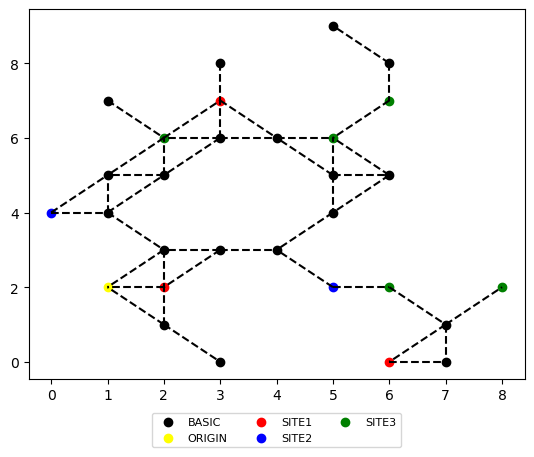

In [4]:
print(f"Problem budget constraint: {cfg.budget}")
print(f"Problem duration constraint: {cfg.duration_time}")
print(f"Worker cost rates per timestep: {cfg.worker_cost_rate}")
cfg.graph.print_graph()

Such `Configuration` object contains a dictionary under `config` attribute. It is in the following format:
```python
{
    worker_type_1:
        {
            worker_1:
                {
                    timestep_1: Config_Single_Time,
                    timestep_2: Config_Single_Time,
                    ...
                    timestep_n: Config_Single_Time,
                },
            worker_2:
                {
                    timestep_1: Config_Single_Time,
                    timestep_2: Config_Single_Time,
                    ...
                    timestep_n: Config_Single_Time,
                }
            ...
            worker_n:
                {
                    timestep_1: Config_Single_Time,
                    timestep_2: Config_Single_Time,
                    ...
                    timestep_n: Config_Single_Time,
                }
        }
    ...
    worker_type_n:
        {
            worker_1:
                {
                    timestep_1: Config_Single_Time,
                    timestep_2: Config_Single_Time,
                    ...
                    timestep_n: Config_Single_Time,
                },
            worker_2:
                {
                    timestep_1: Config_Single_Time,
                    timestep_2: Config_Single_Time,
                    ...
                    timestep_n: Config_Single_Time,
                }
            ...
            worker_n:
                {
                    timestep_1: Config_Single_Time,
                    timestep_2: Config_Single_Time,
                    ...
                    timestep_n: Config_Single_Time,
                }
        }
}
```

The goal of this challenge is to fill it in the most optimal way.
Each timestep has a `Config_Single_Time` object, which at the beginning. 
An example below:

In [5]:
# The indexes are cfg.config[worker_type][worker_number][timestep]
print(cfg.config[Worker_Type.WORKER1][0][0])
cfg.config[Worker_Type.WORKER1][0][0].info()

[(None, None), None, False]

Config_Single_Time is expected to be filled with the following information:\
`[(x_coordinate, y_coordinate), vertex_type, is_accessed]`
e.g.
`[(1, 3), Vertex_Type.SITE1, True]`

Once you are ready with your solution you can save it in `json` format and submit it.

In [6]:
cfg.save_to_json('test_solution.json')

## 2. Create configuration and random graph with custom parameters
During the challenge it is important to remember that given graph is not the one that final solution will be tested on. Therefore the goal is to create an algorithm that finds optimal schedule for any configuration. That's the whole reason why you are provided with tools to create your own graphs and configurations, that you may test your algorithm on.

Below we provide an example of how to create configuration with random graph based on provided parameters.
<div class="alert alert-block alert-danger"><b>Danger:</b> WARNING: IF YOU PROVIDE A GRAPH FILENAME AND GRAPH ARGUMENTS, THEN ORIGINAL GRAPH ARGUMENTS ARE GOING TO BE OVERWRITTEN WITH THE ONES PROVIDED IN LIST!!
</div>

In [7]:
duration = 20 # amount of timesteps in problem
duration = str(int(duration))
arg_list = [
    '--trial_name', 'random',    # name of trial
    '--budget', '1000',          # budget that will be used by hiring workers of different types
    '--duration', duration,      # amount of timesteps in problem
    '--worker1_cost', '100',     # Worker_Type.WORKER1 cost/timestep which reduces our budget
    '--worker2_cost', '200',     # Worker_Type.WORKER2 cost/timestep which reduces our budget
    '--worker3_cost', '500',     # Worker_Type.WORKER3 cost/timestep which reduces our budget
    ################## BELOW GRAPH ARGUMENTS ####################
    '--filename_graph', '',      # if loading graph, max_x, max_y, num_verts, graph_type, num_site[k] (k=1,2,3) ignored
    '--max_x', '10',             # max x coordinate during random or grid graph creation
    '--max_y', '10',             # max y coordinate during random or grid graph creation
    '--num_verts', '30',         # amount of vertices (travel points) that the graph will have
    '--graph_type', 'random',    # type of graph, either 'random' or 'grid' the difference between these is shown further in notebook
    '--num_site1', '3',          # amount of Vertex_Type.SITE1 on the graph mind that amount of all sites cannot be greater than 'num_verts-1'
    '--num_site2', '2',          # amount of Vertex_Type.SITE2 on the graph mind that amount of all sites cannot be greater than 'num_verts-1'
    '--num_site3', '5',          # amount of Vertex_Type.SITE3 on the graph mind that amount of all sites cannot be greater than 'num_verts-1'
    '--site1_acquire_time', '2',    # if args starting with 'site' are specified, they are imposed on loaded graph
    '--site2_acquire_time', '4',    # timesteps needed to extract Vertex_Type.SITE2 reward
    '--site3_acquire_time', '6',    # timesteps needed to extract Vertex_Type.SITE3 reward
    '--site1_reward', '100',     # reward from extracting Vertex_Type.SITE1
    '--site2_reward', '200',     # reward from extracting Vertex_Type.SITE2
    '--site3_reward', '300',     # reward from extracting Vertex_Type.SITE3
]

`lyra_graphtool.ProcessArgs` takes care of provided arguments and creates or loads a graph. You need to initiate this object to process the argument list, that will be further passed as `lyra_graphtool.Parameters` to `lyra_graphtool.Configuration` object. You can save both parameters to a file and graph to a json file to load them later with use of `lyra_graphtool` package.

**DEMONSTRATION**
1. Create `ProcessArgs` object, save parameters and graph.
2. Load saved arguments and graph.

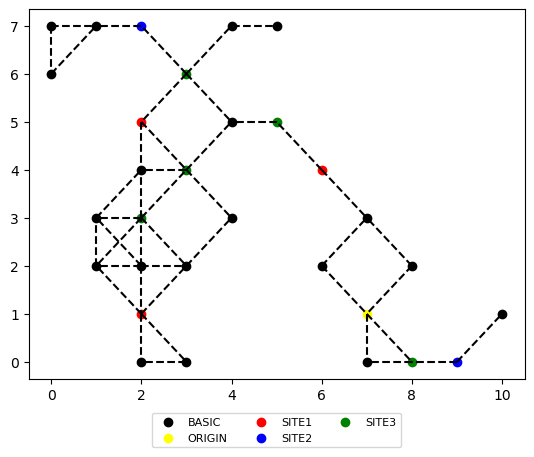

In [8]:
# set up args with above site info
pargs = lgtool.ProcessArgs(arg_list)  # default args

pargs.graph.print_graph()

pargs.graph.save_to_json(f'ready_setups/graph_{pargs.args_trial.trial_name}.json')  # save graph
pargs.save(f'ready_setups/args_{pargs.args_trial.trial_name}') # save args

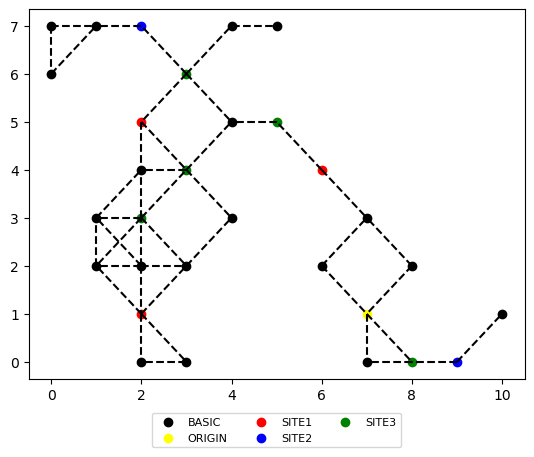

In [9]:
pargs = lgtool.ProcessArgs.load(arguments_file='ready_setups/args_random', graph_file='ready_setups/graph_random.json')
pargs.graph.print_graph()

Finally in order to create our random configuration we need to initiate `Parameters` object with graph, budget, duration time and dictionary of worker cost rates pass this object to `Configuration()`.

In [10]:
params = lgtool.Parameters(pargs.graph, 
                           budget = pargs.args_trial.budget, 
                           duration_time = pargs.args_trial.duration,
                           cost_rate = pargs.worker_cost_rate
                           )

co_base = lgtool.Configuration(params)

## 3. Example solution - Random Walk

Below an example solution of a problem is presented. The solution hires random amount of workers, that will operate for a random amount of time, moving to random positions and accessing sites randomly with given probability. The solution works for regardless of given graph and constraints, but obviously does not provide an optimal solution. It also contains some useful functions and methods, that will be described in Chapter 5.

In [11]:
def random_alg(co_orig:lgtool.Configuration, access_probability:int = 0.5) -> int:
    
    # create config with empty scedules; ie all Config_Single_Time = (None, False)
    co = deepcopy(co_orig)
    worker_types = co.worker_types
    for wt in worker_types:
        for wn in range(len(co.config[wt])):
            for t in range(len(co.config[wt][wn])):
                co.config[wt][wn][t] = lgtool.Config_Single_Time()

    current_workers = co.get_current_workers(co.config)

    available_workers = 0
    for wt in worker_types:
        available_workers += co.max_workers[wt]

    # start all schedules at ORIGIN
    v_orig = co.graph.get_vertices_type(lgtool.Vertex_Type.ORIGIN)[0]
    cs_orig = lgtool.Config_Single_Time(v = v_orig)

    # add workers until exceed budget or no more workers available
    cost_config = co.cost()
    cost_under_budget = True
    while cost_under_budget and available_workers > 0:

        # TYPE: choose a random worker type
        enough_workers = False
        while not enough_workers:
            wt_rand = randint(0,len(worker_types)-1)
            # can we add one more worker of chosen type?
            enough_workers = current_workers[wt_rand] < co.max_workers[wt_rand]

        wt = wt_rand                   # worker type
        wn = current_workers[wt_rand]  # worker number

        sched = deepcopy(co.config[wt][wn])   # schedule to create

        w = co.get_worker(wt)

        # DURATION
        # get random duration and random start time
        duration = randint(1, co.duration_time - 1)
        time_start = randint(0, co.duration_time - duration - 1)
        time_end = time_start + duration

        # start at origin
        # add to schedule and update cost
        sched_or = deepcopy(sched)
        sched_or[time_start] = cs_orig
        co.config[wt][wn] = sched_or
        cost_config = co.cost()

        if cost_config > co.budget:
            cost_under_budget = False
            co.config[wt][wn] = sched    # set sched back to original
            continue

        # random walk
        cs_prev = cs_orig
        t = time_start + 1
        while t < time_end:

            sched = deepcopy(co.config[wt][wn])  # remember current sched

            # pick random next vertex
            verts_adj = co.graph.adjacent_vertices(cs_prev.v)
            ind_next_vert = randint(0, len(verts_adj)-1)
            v_next = verts_adj[ind_next_vert]
            # ACCESS
            if w.access(v_next) and not co.site_accessed_at_time(v_next,t):
                p = random.uniform(0,1)
                access = True if p <= access_probability else False
            else:
                access = False

            # set next Config_Single_Time's in schedule if accessing
            time_to_acq = v_next.time_to_acquire
            config_t_set = False     # True when a config is found for this case
            if access:
                if t + time_to_acq < co.duration_time:
                    # enough time to access

                    # set up schedule that accesses site
                    cs_access = lgtool.Config_Single_Time(v_next, access=True)
                    sched_access = deepcopy(sched)
                    for ta in range(t, t + time_to_acq):
                        sched_access[ta] = deepcopy(cs_access)

                    # set config schedule to access: is this within budget AND not being accessed?
                    co.config[wt][wn] = sched_access
                    feas = co.feasible()

                    if feas:
                        config_t_set = True
                        t += v_next.time_to_acquire    # move forward after access
                        cs_prev = deepcopy(cs_access)

                    else:  
                        co.config[wt][wn] = sched      # set back to original undecided sched

            if config_t_set == False:  # either not accessing, or not enough time to access
                # try no access config
                cs_no_access = lgtool.Config_Single_Time(v_next, access=False)
                sched_no_access = deepcopy(sched)
                sched_no_access[t] = deepcopy(cs_no_access)

                co.config[wt][wn] = sched_no_access

                within_budget = co.cost() < co.budget

                if within_budget:
                    config_t_set = True
                    t += 1                         # move forward after access
                    cs_prev = deepcopy(cs_no_access)
                else:  
                    co.config[wt][wn] = sched      # set back to original undecided sched
            if config_t_set == False:   # over budget in every case
                cost_under_budget = False    # break out of outside while over workers
                break                        # break out of time while

        current_workers = co.get_current_workers(co.config) # update count of current workers
        available_workers -= 1
        
    if co.cost() > 0:
        profit = co.revenue() - co.cost()
    else:
        profit = None
    
    return profit, co

In [27]:
co = deepcopy(co_base)

access_probability = 1    # access a site with this probability

profit, co = random_alg(co, access_probability)
random_accesses, random_message = co.get_accessed_sites(co.config)
print(f"Sites accessed: {random_accesses}")
print(random_message)

print(f'Random configuration PROFIT = {profit}.')

Sites accessed: {(3.0, 6.0): 0, (3.0, 4.0): 0, (6.0, 4.0): 0, (9.0, 0.0): 0, (5.0, 5.0): 0, (2.0, 1.0): 0, (2.0, 3.0): 0, (2.0, 5.0): 0, (2.0, 7.0): 0, (8.0, 0.0): 0}
Log of accesses:

Random configuration PROFT = -900.0.


In [13]:
co.save_to_json(f'solution_{pargs.args_trial.trial_name}.json')

## **APPENDIX:** Create your own graph

### Add and remove vertices

The Test Graph and Final Evaluation Graphs are large and complex. We recommend you progressively build your algorithm by using the `lyra_graphtool` `ProcessArgs` class to build more complex random graphs and to check your performance. There might also be a situation when you would like to test some very specific graph setup (e.g. you realized, that your algorithm fails on specific site-density-distance combination). That is why we added `add_vertex(v: Vertex)` and `remove_vertex(x: float, y: float)` methods to `Graph` class. This way you can modify existing graphs to your needs or even create a completely new graph.

We start by loading prepared arguments and graph.\
**OPTIONAL**: you may create a new setup instead by using a list of parameters as in chapter 2

In [14]:
pargs = lgtool.ProcessArgs.load(arguments_file='ready_setups/args_sample', graph_file='ready_setups/graph_sample.json')

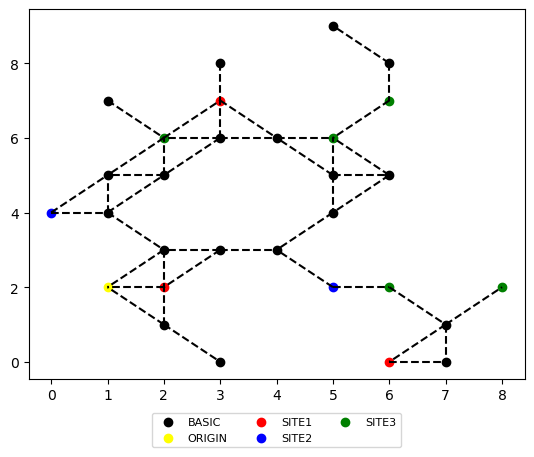

In [15]:
pargs.graph.print_graph()

We can add a new vertex in the following way:
1. We create a `Vertex` object - it is necessary to provide x and y coordinates and vertex type (the default is BASIC), other parameters such as site rewards or time needed to acquire reward are set automatically based on arguments provided to `ProcessArgs`
2. We use `lgtool.Graph.add_vertex()` method to add a vertex to graph

<div class="alert alert-block alert-danger"><b>Danger:</b> WARNING: MAKE SURE YOU ADD VERTEX THAT IS ADJACENT TO SOME OTHER VERTEX, OTHERWISE IT WILL BE MOVED AUTOMATICALLY UNTIL ALL VERTICES ARE ACCESSIBLE FROM ORIGIN!
</div>

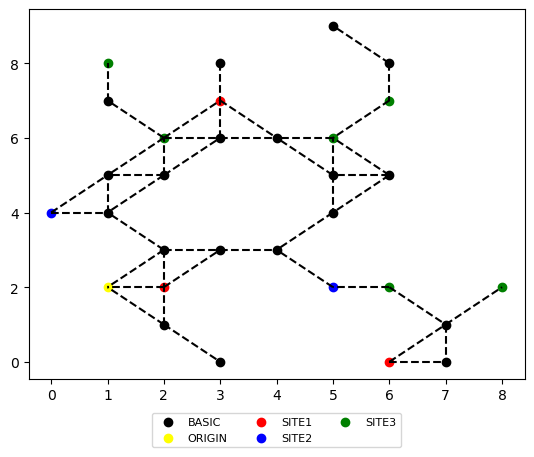

In [16]:
v = Vertex(0, 9, lgtool.Vertex_Type.SITE3)
pargs.graph.add_vertex(v)
pargs.graph.print_graph()

In order to remove a vertex from a graph simply use `lgtool.Graph.remove_vertex()` and provide x and y coordinates as presented below.

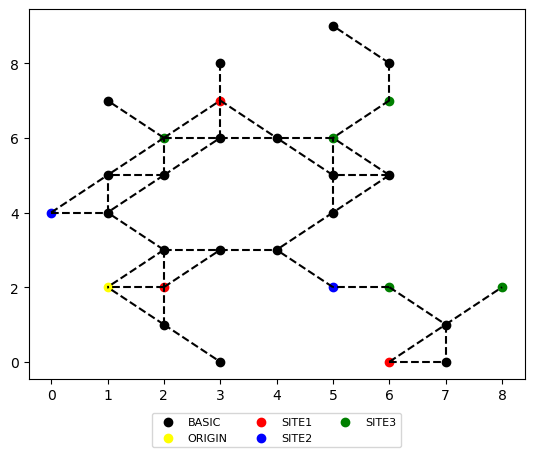

In [17]:
pargs.graph.remove_vertex(x=1, y=8)
pargs.graph.print_graph()

The following appendix shows the possibilities to operate on `Graph` object and presents the difference between `GRID` and `RANDOM` graphs.

In order to create any type of graph we recommend using `ProcessArgs` object with number of vertices, horizontal, vertical max sizes and graph type defined. `GRID` graph is created as a regular network of connected vertices, while `RANDOM` graph randomly selects locations of vertices. Below are examples of graphs created in this way.
There are two types of graphs in module: `RANDOM` and `GRID`. We can use `Graph.print_graph()` to visualize graph.

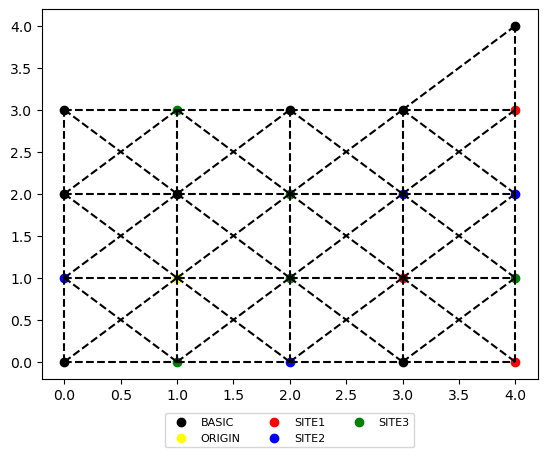

In [18]:
arg_list = [
    '--filename_graph', '',      # if loading graph, max_x, max_y, num_verts, graph_type, num_site[k] (k=1,2,3) ignored
    '--max_x', '10',             # max x coordinate during random or grid graph creation
    '--max_y', '10',             # max y coordinate during random or grid graph creation
    '--num_verts', '21',         # amount of vertices (travel points) that the graph will have
    '--graph_type', 'grid',    # type of graph, either 'random' or 'grid' the difference between these is shown further in notebook
    '--num_site1', '3',          # amount of Vertex_Type.SITE1 on the graph mind that amount of all sites cannot be greater than 'num_verts-1'
    '--num_site2', '4',          # amount of Vertex_Type.SITE2 on the graph mind that amount of all sites cannot be greater than 'num_verts-1'
    '--num_site3', '5',          # amount of Vertex_Type.SITE3 on the graph mind that amount of all sites cannot be greater than 'num_verts-1'
    '--site1_acquire_time', '2',    # if args starting with 'site' are specified, they are imposed on loaded graph
    '--site2_acquire_time', '4',    # timesteps needed to extract Vertex_Type.SITE2 reward
    '--site3_acquire_time', '6',    # timesteps needed to extract Vertex_Type.SITE3 reward
    '--site1_reward', '100',     # reward from extracting Vertex_Type.SITE1
    '--site2_reward', '200',     # reward from extracting Vertex_Type.SITE2
    '--site3_reward', '300',     # reward from extracting Vertex_Type.SITE3
]
pargs = lgtool.ProcessArgs(arg_list)
pargs.graph.print_graph()

Below is an example of creating a `RANDOM` graph

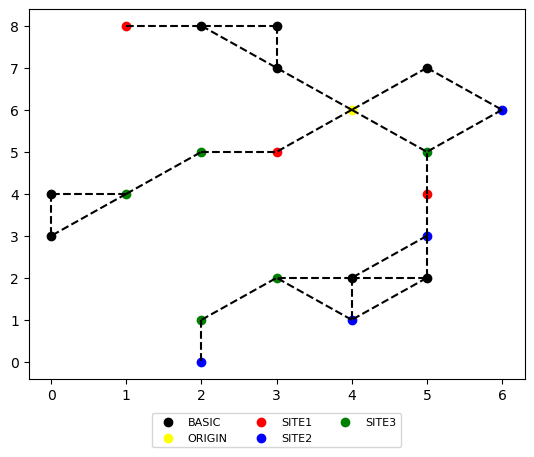

In [19]:
arg_list = [
    '--filename_graph', '',      # if loading graph, max_x, max_y, num_verts, graph_type, num_site[k] (k=1,2,3) ignored
    '--max_x', '10',             # max x coordinate during random or grid graph creation
    '--max_y', '10',             # max y coordinate during random or grid graph creation
    '--num_verts', '21',         # amount of vertices (travel points) that the graph will have
    '--graph_type', 'random',    # type of graph, either 'random' or 'grid' the difference between these is shown further in notebook
    '--num_site1', '3',          # amount of Vertex_Type.SITE1 on the graph mind that amount of all sites cannot be greater than 'num_verts-1'
    '--num_site2', '4',          # amount of Vertex_Type.SITE2 on the graph mind that amount of all sites cannot be greater than 'num_verts-1'
    '--num_site3', '5',          # amount of Vertex_Type.SITE3 on the graph mind that amount of all sites cannot be greater than 'num_verts-1'
    '--site1_acquire_time', '2',    # if args starting with 'site' are specified, they are imposed on loaded graph
    '--site2_acquire_time', '4',    # timesteps needed to extract Vertex_Type.SITE2 reward
    '--site3_acquire_time', '6',    # timesteps needed to extract Vertex_Type.SITE3 reward
    '--site1_reward', '100',     # reward from extracting Vertex_Type.SITE1
    '--site2_reward', '200',     # reward from extracting Vertex_Type.SITE2
    '--site3_reward', '300',     # reward from extracting Vertex_Type.SITE3
]
pargs = lgtool.ProcessArgs(arg_list)
pargs.graph.print_graph()

A `Graph` method that you may find particularly useful is `paths`. Provided with two vertices you are interested in it returns all possible paths connecting them.

[(5, 3), <Vertex_Type.SITE2: 3>] [(0, 3), <Vertex_Type.BASIC: 0>]






[(5, 3),
 (5, 4),
 (5, 5),
 (6, 6),
 (5, 7),
 (4, 6),
 (3, 5),
 (2, 5),
 (1, 4),
 (0, 4),
 (0, 3)]

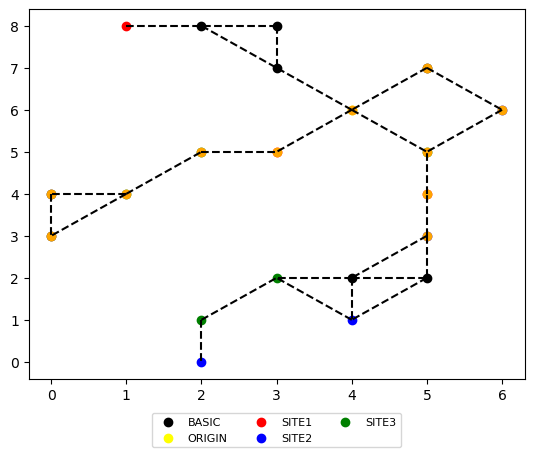

[(5, 3),
 (5, 4),
 (5, 5),
 (6, 6),
 (5, 7),
 (4, 6),
 (3, 5),
 (2, 5),
 (1, 4),
 (0, 3)]

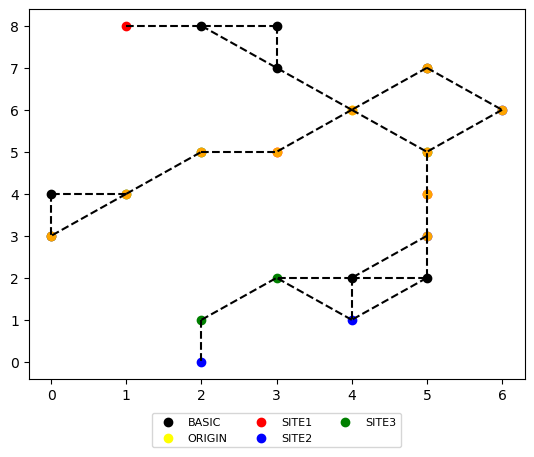

[(5, 3), (5, 4), (5, 5), (4, 6), (3, 5), (2, 5), (1, 4), (0, 4), (0, 3)]

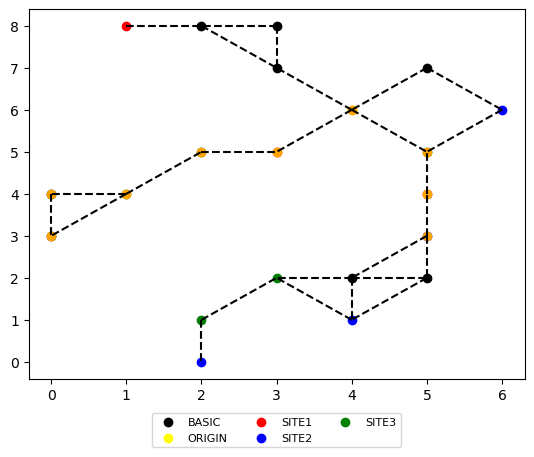

[(5, 3), (5, 4), (5, 5), (4, 6), (3, 5), (2, 5), (1, 4), (0, 3)]

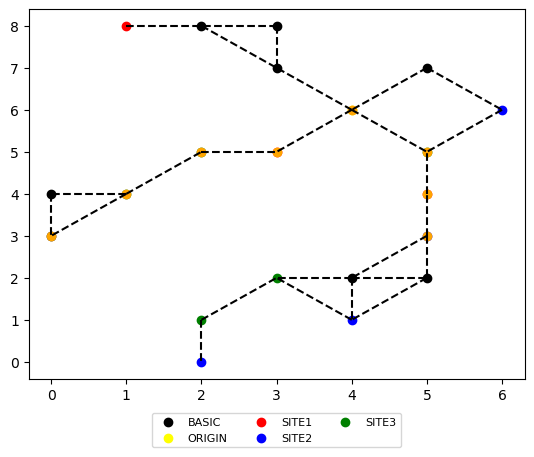

In [20]:
# get two verts and then get paths between them
verts = pargs.graph.vertices

# pick first and last vertex in the list
v1 = verts[0]
v2 = verts[-1]

print(v1.info(),v2.info())
print('\n')
paths12 = pargs.graph.paths(v1,v2)

print('\n')
for p in paths12:
    path = []
    for v in p:
        path.append((v.x,v.y))
        
    display(path)
    # print_graph() method when provided with a list of vertices, highlights them in orange
    pargs.graph.print_graph(p)

List of other helpful methods of `Graph` class:
1. `Graph.vertices_info()` - returns coordinates and types of vertices in a graph
2. `Graph.edges_info()` - returns edges in a graph
3. `Graph.get_vertices_type(vtype: VertexType)` - returns a list of vertices of given type
4. `Graph.get_vertex_xy(x: float, y: float)` - returns a vertex object of given coordinates
5. `Graph.get_edges_at_vertex(v: Vertex)` - returns a list of edge for a given vertex
6. `Graph.adjacent_vertices(v: Vertex)` - returns a list of adjacent vertices to a given vertex
7. `Graph.save_to_json()` - saves graph to a json file
8. `Graph.load_from_json(file_name: str)` - loads graph from json file
 
List of methods for manual creation/modification of graph:
1. `Graph.set_vertex_type(vtype: VertexType, v: Vertex, x: float, y: float)` - setting a type of particular Vertex manually, based on either Vertex object passed to method or Vertex coordinates - in that case both coordinates have to be provided 
2. `Graph.set_vertex_coords(v: Vertex, x: float, y: float)` - manually changing Vertex coordinates for a given Vertex
3. `Graph.set_site_acquire_times(acquire times: Dict)` - sets acquire times for sites

List of helpful methods of `Vertex` class:
1. `Vertex.info()` - returns coordinates and type of Vertex
2. `Vertex.accessible_types()` - returns which types of vertices are accessible

List of helpful methods of `Edge` class:
1. `Edge.info()` - returns coordinates of vertices connected by this edge

## **APPENDIX:** `Configuration` Class

Many of `Configuration` methods operate either on the whole schedule/configuration, which is a dictionary shown in Chapter 1 and sits under `Configuration.config` attribute or single schedule, which is a dictionary schedule for single worker, that sits under `Configuration.config[worker_type][worker_number]`. In the below list methods taking as argument whole configuration will be marked as **[WS]** and single schedule as **[SS]**.

a) `lyra_graphtool.Config_Single_Time.info()` - returns information about Vertex coordinates, type and whether it was accessed or not\
b) `lyra_graphtool.Configuration.get_vertices_start()` - returns vertices of type Vertex_Type.ORIGIN\
c) `lyra_graphtool.Configuration.sched_info(sched: Dict)` - **[SS]** prints information about specific workers schedule in form `[timestep, (x_coordinate, y_coordinate), Vertex_Type, accessed/not accessed]`\
d) `lyra_graphtool.Configuration.get_worker(wt: Worker_Type)` - returns Worker object of specific type, making sure it has proper cost_rate assigned\
e) `lyra_graphtool.Configuration.get_current_workers(config: Dict)` - **[WS]** returns a dictionary of workers that are active in configuration\
f) `lyra_graphtool.Configuration.get_accessed_sites(schedule: Dict)` - **[WS]** returns summary dictionary of accessed sites and a string log of detailed accesses\
g) `lyra_graphtool.Configuration.get_max_revenue()` - returns maximum reward available in current setup\
h) `lyra_graphtool.Configuration.site_accessed_at_time(v: Vertex, t: int)` - provided with Vertex and timestep returns whether the site has been accessed at particular time step\
i) `lyra_graphtool.Configuration.site_accessed(v: Vertex)` - provided with Vertex returns an information whether the site has been accessed at any point in time in schedule\
j) `lyra_graphtool.Configuration.get_sched_path_length(sched: Dict)` - **[SS]** provided with schedule returns it's path length, answers the question: for how many timesteps has the worker been active?\
k) `lyra_graphtool.Configuration.is_empty(sched: Dict)` - **[SS]** returns whether schedule is empty\
l) `lyra_graphtool.Configuration.cost_sched(sched: Dict, worker: Worker)` - **[SS]** returns the cost of a single schedule\
m) `lyra_graphtool.Configuration.cost()` - returns the cost of whole configuration\
n) `lyra_graphtool.Configuration.sched_revenue(sched: Dict)` - **[SS]** returns revenue of single schedule\
o) `lyra_graphtool.Configuration.revenue()` - returns revenue of whole configuration\
p) `lyra_graphtool.Configuration.save_to_json(file_name: str)` - saves solution as `.json` file\
r) `lyra_graphtool.Configuration.load_from_json(file_name: str)` - loads solution from `.json` file

Below is the list of methods, that allow you to test your solution for feasibility regarding problem constraints. There are 3 main feasibilities: 
 - space feasibility - is the worker allowed to move chosen path, are all his moves to connected and adjacent vertices? Worker can move only distance of length 1 in 1 timestep
 - access feasibility - is the worker allowed to access vertex
 - budget feasibility - do we have enough money to pay all workers

a) `lyra_graphtool.Configuration.sched_feasible_space(sched: Dict)` - **[SS]** tests whether single schedule is feasible in terms of space\
b) `lyra_graphtool.Configuration.sched_all_feasible_space()` - tests whether whole configuration is spatialy feasible\
c) `lyra_graphtool.Configuration.sched_feasible_access_sites(sched: Dict, worker_type: Worker_Type)` - **[SS]** tests whether single schedule pass access constraints - one site can be accessed by 1 worker at a time and once the reward is extracted it doesn't contain more reward\
d) `lyra_graphtool.Configuration.sched_all_feasible_access_sites()` - tests whether the whole configuration can pass access constraints\
e) `lyra_graphtool.Configuration.budget_feasible()` - tests whether the whole configuration can pass budget constraints\
f) `lyra_graphtool.Configuration.feasible()` - tests whether the whole configuration is feasible in all terms

Below are usage examples of some of the methods on configuration generated by Random Walk algorithm presented above.

`lyra_graphtool.Configuration.sched_info()` is a very useful method, that lets you examine particular schedule in detail. It's very useful, when you want to see what algorithm generated and what could have went wrong.

In [21]:
# indexing config: co.config[worker_type][worker_number]
co.sched_info(co.config[Worker_Type.WORKER1][0])

['[t=0, (None,None), vtype=None, acc=False ]',
 '[t=1, (None,None), vtype=None, acc=False ]',
 '[t=2, (None,None), vtype=None, acc=False ]',
 '[t=3, (None,None), vtype=None, acc=False ]',
 '[t=4, (None,None), vtype=None, acc=False ]',
 '[t=5, (None,None), vtype=None, acc=False ]',
 '[t=6, (None,None), vtype=None, acc=False ]',
 '[t=7, (None,None), vtype=None, acc=False ]',
 '[t=8, (7.0,1.0), vtype=1, acc=False ]',
 '[t=9, (8.0,0.0), vtype=4, acc=False ]',
 '[t=10, (9.0,0.0), vtype=3, acc=False ]',
 '[t=11, (None,None), vtype=None, acc=False ]',
 '[t=12, (None,None), vtype=None, acc=False ]',
 '[t=13, (None,None), vtype=None, acc=False ]',
 '[t=14, (None,None), vtype=None, acc=False ]',
 '[t=15, (None,None), vtype=None, acc=False ]',
 '[t=16, (None,None), vtype=None, acc=False ]',
 '[t=17, (None,None), vtype=None, acc=False ]',
 '[t=18, (None,None), vtype=None, acc=False ]',
 '[t=19, (None,None), vtype=None, acc=False ]']

`lyra_graphtool.Configuration.get_current_workers()` is very useful to follow and access current amount of workers, it structures amount of workers used by type.

In [28]:
co.get_current_workers(co.config)

{<Worker_Type.WORKER1: 0>: 1,
 <Worker_Type.WORKER2: 1>: 1,
 <Worker_Type.WORKER3: 2>: 0}

`lyra_graphtool.Configuration.get_accessed_sites()` is also very useful method for inspecting your solution. Summary dictionary provides the aggregate number of accesses for each Vertex, which not only informs you which of the sites where accessed, but can also help you identify, whether any of them has been accessed more than once, which is a constraint violation.

For more detailed debugging of your solution access log is provided, which also tells you at which time step each access happened.

In [23]:
access_dict, access_logs = co.get_accessed_sites(co.config)
print(access_dict)
print(access_logs)

{(3.0, 6.0): 0, (3.0, 4.0): 0, (6.0, 4.0): 0, (9.0, 0.0): 1, (5.0, 5.0): 0, (2.0, 1.0): 0, (2.0, 3.0): 0, (2.0, 5.0): 0, (2.0, 7.0): 0, (8.0, 0.0): 1}
Log of accesses:
Worker_Type.WORKER3 number 0 accessed Vertex_Type.SITE3 at (8.0, 0.0) at time step 12
Worker_Type.WORKER3 number 0 accessed Vertex_Type.SITE2 at (9.0, 0.0) at time step 16



Below we will demonstrate how to use one of the tests, that takes two objects as arguments, which tests whether the access feasibility is met

In [26]:
# Lets get some worker object from current configuration, e.g. Worker_Type.WORKER2 - depending on the result of Random Walk might not be available
# then in order to run this cell change the worker type or rerun the Random Walk until you get desired worker type
worker = co.get_worker(Worker_Type.WORKER2)

# And also extract a schedule for the first worker from this type
schedule = co.config[Worker_Type.WORKER2][0]

# Run the test
co.sched_feasible_access_sites(schedule, worker)

True

We can see, that Random Walk solution passes this test